# 機械学習帳 確認問題(3.4)

[機械学習帳のモデル選択と正則化の確認問題(3.4)を解きます](https://chokkan.github.io/mlnote/regression/03regularization.html#id4)。

## 講義内容の復習

![chapter3-1.PNG](./images/chapter3/chapter3-1.PNG)

## 0. データの準備

演習用のデータを定義します。

In [1]:
import numpy as np


X = np.array([ 0.  ,  0.16,  0.22,  0.34,  0.44,  0.5 ,  0.67,  0.73,  0.9 ,  1.  ])
Y = np.array([-0.06,  0.94,  0.97,  0.85,  0.25,  0.09, -0.9 , -0.93, -0.53,  0.08])

## 1. 9次関数によるリッジ回帰

リッジ回帰を行うクラス`RidgeRegression`を作成します。`degree`に応じた特徴量の作成には`PolynomialFeatures`を使用します。

In [2]:
from sklearn.preprocessing import PolynomialFeatures


class RidgeRegression:
    
    def __init__(self, degree):
        self.degree = degree
        self.w = None
    
    def train(self, X, Y, alpha=1.0):
        transformer = PolynomialFeatures(self.degree, include_bias=True)
        F = transformer.fit_transform(X.reshape((-1, 1)))
        y = Y.reshape((-1, 1))
        self.w = np.linalg.inv(F.T @ F + (alpha * np.eye(F.shape[-1]))) @ F.T @ y
        return self
    
    def predict(self, X):
        transformer = PolynomialFeatures(self.degree, include_bias=True)
        F = transformer.fit_transform(X.reshape((-1, 1)))
        return (F @ self.w).flatten()
        

In [3]:
model = RidgeRegression(degree=9).train(X, Y, alpha=1.0)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(PolynomialFeatures(9, include_bias=False), Ridge(alpha=1.0))
pipeline.fit(X.reshape(-1, 1), Y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=9, include_bias=False)),
                ('ridge', Ridge())])

In [5]:
w9 = np.hstack([np.array([pipeline[-1].intercept_]), pipeline[-1].coef_])

Assertはエラーになります(大体同じ値ではあるものの)。ここはちょっと原因を特定できていません。

In [6]:
# np.testing.assert_allclose(model.w.flatten(), w9)

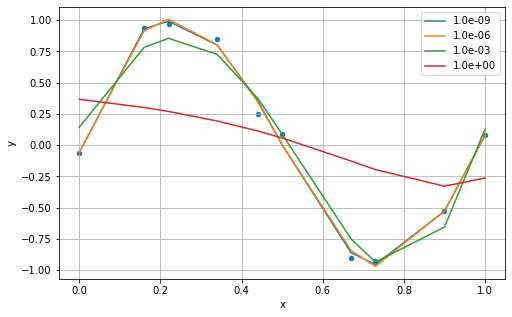

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


models = {}
data = {"x": X, "y": Y}
for alpha in (1e-9, 1e-6, 1e-3, 1.0):
    key = f"{alpha:.1e}"
    model = RidgeRegression(degree=9).train(X, Y, alpha=alpha)
    models[key] = model
    data[key] = model.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
df = pd.DataFrame(data)
df.plot.scatter(x="x", y="y", grid=True, ax=ax)
for key in models:
    df.plot.line(x="x", y=key, grid=True, ax=ax)

## 2.パラメータのL2ノルム

各モデルのL2ノルムを計算します。Ridge回帰上のL2ノルムはsqrtを取っていませんが、ここでは定義に準じてとっています。

In [8]:
for key in models:
    print(f"L2 norm of alpha={key} = {np.sqrt(models[key].w.T @ models[key].w).flatten()[0]}")

L2 norm of alpha=1.0e-09 = 458.6911433168437
L2 norm of alpha=1.0e-06 = 26.730316772473522
L2 norm of alpha=1.0e-03 = 15.945465648148522
L2 norm of alpha=1.0e+00 = 0.7661357524858884


## 3. 検証データに基づく$\alpha$の選択

検証データに対し最も平均二乗残差が小さくなる$alpha$を探索します。

In [9]:
X_valid = np.array([ 0.05,  0.08,  0.12,  0.16,  0.28,  0.44,  0.47,  0.55,  0.63,  0.99])
Y_valid = np.array([ 0.35,  0.58,  0.68,  0.87,  0.83,  0.45,  0.01, -0.36, -0.83, -0.06])

In [10]:
msrs = {}

for key in models:
    msrs[key] = np.mean((Y_valid - models[key].predict(X_valid)) ** 2)

msrs

{'1.0e-09': 0.010502322114567846,
 '1.0e-06': 0.010066159816417234,
 '1.0e-03': 0.017790450111697435,
 '1.0e+00': 0.17280430903144864}

In [11]:
print(f"Best model is alpha={min(msrs, key=msrs.get)}, mse={min(msrs.values())}")

Best model is alpha=1.0e-06, mse=0.010066159816417234
